<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw5_hpo_autogluon/hpo_autogluon_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is the story

This note book is to predict the instant power consumption based on smart home sensor data and latent variables <br />
Dataset<br />
&nbsp;  &nbsp; &nbsp; Home C sensor data set in 2015<br />

Objective fuction<br />
Predict instant power consumption based on sensor data solar energy and latent variables -- weather info<br />
We will optimise hyper parameters for RandomForestRegressor and MLPRegressor, also will use autogluon to complete the prediction and compare the results.



In [1]:
# Uninstall mkl for faster neural-network training time
!pip uninstall -qy mkl
# Upgrade pip to ensure the latest package versions are available
!pip install -qU pip
# Upgrade setuptools to be compatible with namespace packages
!pip install -qU setuptools
!pip install -qU "mxnet<2.0.0"
# Install pre-release, frozen to a particual pre-release for stability
!pip install -q --pre "autogluon==0.0.16b20201214"
!pip install -qU ipykernel

In [2]:
from autogluon.tabular import TabularPrediction as task
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from io import BytesIO


Load the dataset which has aggregated the sensor power consumption data combined with weather data of Home C.

In [3]:
train_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTAH13xa_KY8QeIy48jCgbAY7OkFQCQYfHh-7Nt-TgXKTBeH8buWJZ6Izm91LxIXCo9W9oebwmbgbeF/pub?output=csv#'
r = requests.get(train_url)
data = r.content
stats = pd.read_csv(BytesIO(data))
stats.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282,0.0,24.4,0.0


### Data preprosessing
Remove unit(kW) from dataset column names.

In [4]:
stats.columns = [i.replace(' [kW]', '') for i in stats.columns]

'cloudCover' value was found in the column, let's replace these invalid values with the next valid value.

In [5]:
stats['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
stats['cloudCover'] = stats['cloudCover'].astype('float')
stats.head()

,time,use,gen,House overall,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,Garage door,Kitchen 12,Kitchen 14,Kitchen 38,Barn,Well,Microwave,Living room,Solar,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282,0.0,24.4,0.0


Combine 'Furnace 1' and 'Furnace 2' to 'Furnace', combine 'Kitchen 12' 'Kitchen 14' and 'Kitchen 38' to 'Kitchen'.

In [6]:
stats['Furnace'] = stats[['Furnace 1','Furnace 2']].sum(axis=1)
stats['Kitchen'] = stats[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)

See feature correlations, Solar data is negatively correlated to power consumption, that is expected.

In [7]:
  feature = 'use'
  df_corr = stats.corr()[feature]
  golden_features_list = df_corr[abs(df_corr) > 0.1].sort_values(ascending=True)
  print("There is {} correlated values with feature {}:\n{}"
        .format(len(golden_features_list), feature, golden_features_list))

There is 21 correlated values with feature use:
gen                   -0.309440
Solar                 -0.309440
time                  -0.159069
apparentTemperature   -0.154378
temperature           -0.152890
dewPoint              -0.120681
Kitchen 38             0.107878
Kitchen 14             0.154937
Home office            0.155206
Microwave              0.158953
Kitchen                0.170290
Fridge                 0.188517
Barn                   0.239522
Well                   0.257693
Dishwasher             0.302407
Furnace 1              0.329671
Living room            0.342365
Furnace 2              0.483417
Furnace                0.543849
House overall          1.000000
use                    1.000000
Name: use, dtype: float64


Observe duplicate feature 'use' and 'House overall', 'gen' and 'Solar', remove one of them. <br />
Keep only features which absolute correlation with 'use' > 0.1, not involving duplicate features.

In [8]:
feature_list = ['gen' , 'apparentTemperature', 'temperature', 'dewPoint', 'Kitchen', 'Furnace', \
                'Home office', 'Microwave', 'Fridge', 'Barn', 'Well', 'Dishwasher', 'Living room', 'use']
df = stats[feature_list]
df.head()

,gen,apparentTemperature,temperature,dewPoint,Kitchen,Furnace,Home office,Microwave,Fridge,Barn,Well,Dishwasher,Living room,use
0,0.003483,29.26,36.14,24.4,0.000567,0.082617,0.442633,0.004067,0.124150,0.031350,0.001017,0.000033,0.001517,0.932833
1,0.003467,29.26,36.14,24.4,0.000567,0.084533,0.444067,0.004067,0.124000,0.031500,0.001017,0.000000,0.001650,0.934333
2,0.003467,29.26,36.14,24.4,0.000617,0.083017,0.446067,0.004067,0.123533,0.031517,0.001000,0.000017,0.001650,0.931817
3,0.003483,29.26,36.14,24.4,0.000650,0.175417,0.446583,0.004067,0.123133,0.031500,0.001017,0.000017,0.001617,1.022050
4,0.003467,29.26,36.14,24.4,0.000783,0.300917,0.446533,0.004067,0.122850,0.031500,0.001017,0.000133,0.001583,1.139400


In [9]:
df.shape

(113176, 14)

### Import libraries and split the data for train test

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from time import time

In [11]:
X, y = df.drop(['use'], axis=1), df['use']

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2, shuffle=True)

### Hyperparameters tuning loop on RandomForestRegressor and MLPRegressor

In [20]:
def tuning_hyper_parameters():
  random_grid = {#'Linear Regression', 
           'Random Forest': {'bootstrap': [True, False],
                             'max_depth': [10, 50, 100, None],
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_leaf': [1, 2, 4],
                             'min_samples_split': [2, 5, 10],
                             'n_estimators': [200, 1000, 2000]},
           #'Decision Tree',
          'MLP Regressor': {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
                            'activation': ['relu','tanh','logistic'],
                            'alpha': [0.0001, 0.05],
                            'learning_rate': ['constant','adaptive'],
                            'solver': ['lbfgs','sgd','adam']},
           #'XBoost Regressor',
           #'KNN Regressor'
          }
  regression = [
            #LinearRegression(),
            RandomForestRegressor(),
            #DecisionTreeRegressor(),
            MLPRegressor(),
            #xgb.XGBRegressor(),
            #KNeighborsRegressor(),
          ]
  for name, clf in zip(random_grid.keys(), regression):
    rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid[name], n_iter = 3, cv = 2, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    print('model %s best_params %s' % (name, rf_random.best_params_))

In [21]:
tuning_hyper_parameters()

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  9.7min finished


model Random Forest best_params {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.8min finished


model MLP Regressor best_params {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'logistic'}


### Apply the best parameters in muller loop and compare the results

In [14]:
def muller_loop(X_train, y_train, X_test, y_test):
  names = ['Random Forest',
           'Random Forest Tuning',
           'MLP Regressor',
           'MLP Regressor Tuning',
          ]
  regression = [
            RandomForestRegressor(max_depth=5, n_estimators=10),
            RandomForestRegressor(max_depth=50, n_estimators=200, max_features='sqrt', bootstrap=True, min_samples_leaf=4, min_samples_split=5),
            MLPRegressor(random_state=1, alpha=1, max_iter=1000),
            MLPRegressor(solver='adam', learning_rate= 'adaptive', hidden_layer_sizes= (50, 50, 50), alpha= 0.0001, activation= 'tanh'),
          ]
  result = pd.DataFrame(columns=['model','r2 score', 'mean squared error', 'mean absolute error', 'time'])

  # iterate over classifiers
  for name, clf in zip(names, regression):
      start_time = time()
      clf.fit(X_train, y_train)
      r2 = 100.0 * clf.score(X_test, y_test)
      y_pred = clf.predict(X_test)
      v_score = 100.0 * explained_variance_score(y_test, y_pred, multioutput='raw_values')[0]
      mse =  mean_squared_error(y_test, y_pred)
      mae =  mean_absolute_error(y_test, y_pred)
      result = result.append({'model': name, 'r2 score': r2, 'mean squared error': mse, 'mean absolute error': mae ,'time': (time() - start_time) }, ignore_index=True)

  display(result)


In [15]:
muller_loop(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,model,r2 score,mean squared error,mean absolute error,time
0,Random Forest,62.573965,0.174889,0.243374,2.988457
1,Random Forest Tuning,89.775175,0.047780,0.080040,60.248286
2,MLP Regressor,76.764494,0.108578,0.144515,10.040634
3,MLP Regressor Tuning,86.544679,0.062876,0.120644,304.453364


### Use AutoML AutoGluon to complete the prediction

No output_directory specified. Models will be saved in: AutogluonModels/ag-20210307_031230/
Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20210307_031230/
AutoGluon Version:  0.0.16b20201214
Train Data Rows:    20000
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (7.378916667, 0.000466667, 1.0705, 0.69513)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12518.69 MB
	Train Data (Original)  Memory Usage: 2.08 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_m

Time out (secs) is 67.5


[1000]	train_set's l2: 0.00148299	train_set's r2: 0.802794	valid_set's l2: 0.0250958	valid_set's r2: 0.772544
[1000]	train_set's l2: 0.000955806	train_set's r2: 0.804044	valid_set's l2: 0.0238965	valid_set's r2: 0.774016


	Ran out of time, early stopping on iteration 333. Best iteration is:
	[330]	train_set's l2: 0.0350571	train_set's r2: 0.730968	valid_set's l2: 0.0635707	valid_set's r2: 0.697843
	0.952	 = Validation r2 score
	16.77s	 = Training runtime
	0.43s	 = Validation runtime
	0.9536	 = Validation r2 score
	15.34s	 = Training runtime
	0.51s	 = Validation runtime
	0.9489	 = Validation r2 score
	12.61s	 = Training runtime
	0.31s	 = Validation runtime
	0.9486	 = Validation r2 score
	7.46s	 = Training runtime
	0.14s	 = Validation runtime
	0.8764	 = Validation r2 score
	7.56s	 = Training runtime
	0.18s	 = Validation runtime
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1000


Time out (secs) is 67.5


[1000]	train_set's l2: 0.0117129	train_set's r2: 0.781814	valid_set's l2: 0.033613	valid_set's r2: 0.75556
[1000]	train_set's l2: 0.010963	train_set's r2: 0.784848	valid_set's l2: 0.0328581	valid_set's r2: 0.757519
[1000]	train_set's l2: 0.00850108	train_set's r2: 0.788399	valid_set's l2: 0.0318254	valid_set's r2: 0.75559
[2000]	train_set's l2: 0.00393349	train_set's r2: 0.79714	valid_set's l2: 0.0277642	valid_set's r2: 0.764169


	0.9364	 = Validation r2 score
	14.2s	 = Training runtime
	0.46s	 = Validation runtime
	0.9372	 = Validation r2 score
	15.89s	 = Training runtime
	0.57s	 = Validation runtime
	0.9456	 = Validation r2 score
	31.79s	 = Training runtime
	1.33s	 = Validation runtime
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1000


Time out (secs) is 67.5
	0.9581	 = Validation r2 score
	55.44s	 = Training runtime
	0.05s	 = Validation runtime
	0.9405	 = Validation r2 score
	7.62s	 = Training runtime
	0.02s	 = Validation runtime
	0.7921	 = Validation r2 score
	1.27s	 = Training runtime
	0.01s	 = Validation runtime
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1000


Time out (secs) is 67.5
	0.9262	 = Validation r2 score
	30.32s	 = Training runtime
	0.23s	 = Validation runtime
	0.8648	 = Validation r2 score
	17.73s	 = Training runtime
	0.07s	 = Validation runtime
	0.8622	 = Validation r2 score
	16.05s	 = Training runtime
	0.07s	 = Validation runtime
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1000


Time out (secs) is 67.5
	Ran out of time, stopping training early.
Please either provide filename or allow plot in get_training_curves
	0.7436	 = Validation r2 score
	69.01s	 = Training runtime
	0.3s	 = Validation runtime
Fitting model: WeightedEnsemble_L1 ...
	0.9603	 = Validation r2 score
	0.93s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 413.26s ...
Evaluation: r2 on test data: 0.7357022760935353


*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L1   0.960295       1.106192  92.904907                0.001044           0.927860            1       True         20
1         CatBoost/trial_10   0.958060       0.050505  55.437450                0.050505          55.437450            0       True         13
2          LightGBM/trial_1   0.953586       0.509857  15.338533                0.509857          15.338533            0       True          6
3          LightGBM/trial_0   0.952012       0.425596  16.772475                0.425596          16.772475            0       True          5
4          LightGBM/trial_2   0.948919       0.314077  12.605444                0.314077          12.605444            0       True          7
5          LightGBM/trial_3   0.948558       0.141440   7.463735                

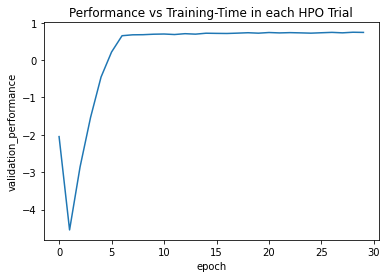

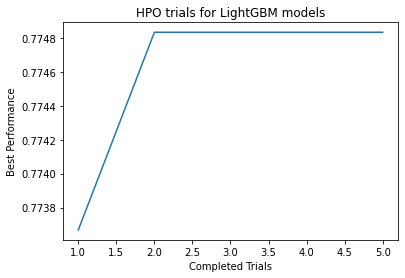

Plot summary of models saved to file: AutogluonModels/ag-20210307_031230/LightGBMXT_HPOmodelsummary.html
Plot summary of models saved to file: LightGBMXT_HPOmodelsummary.html
Plot of HPO performance saved to file: AutogluonModels/ag-20210307_031230/LightGBMXT_HPOperformanceVStrials.png


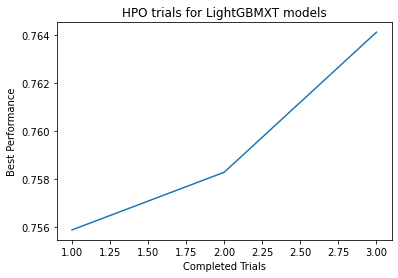

Plot summary of models saved to file: AutogluonModels/ag-20210307_031230/CatBoost_HPOmodelsummary.html
Plot summary of models saved to file: CatBoost_HPOmodelsummary.html
Plot of HPO performance saved to file: AutogluonModels/ag-20210307_031230/CatBoost_HPOperformanceVStrials.png


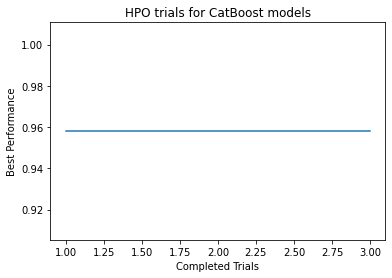

Plot summary of models saved to file: AutogluonModels/ag-20210307_031230/XGBoost_HPOmodelsummary.html
Plot summary of models saved to file: XGBoost_HPOmodelsummary.html
Plot of HPO performance saved to file: AutogluonModels/ag-20210307_031230/XGBoost_HPOperformanceVStrials.png


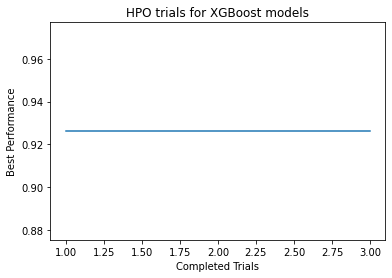

Plot summary of models saved to file: AutogluonModels/ag-20210307_031230/NeuralNetMXNet_HPOmodelsummary.html
Plot summary of models saved to file: NeuralNetMXNet_HPOmodelsummary.html
Plot of HPO performance saved to file: AutogluonModels/ag-20210307_031230/NeuralNetMXNet_HPOperformanceVStrials.png


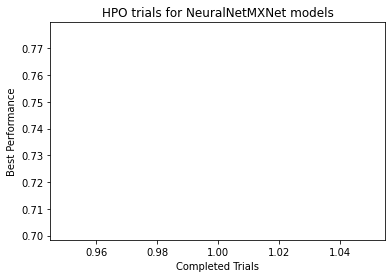

*** Details of Hyperparameter optimization ***
HPO for LightGBM model:  Num. configurations tried = 5, Time spent = 69.03658747673035s, Search strategy = random
Best hyperparameter-configuration (validation-performance: r2 = 0.7748326588759616):
{'feature_fraction': 0.8366535802159208, 'learning_rate': 0.10139387945137676, 'min_data_in_leaf': 24, 'num_leaves': 43}
HPO for LightGBMXT model:  Num. configurations tried = 3, Time spent = 69.18862056732178s, Search strategy = random
Best hyperparameter-configuration (validation-performance: r2 = 0.7641024775745859):
{'feature_fraction': 0.9951451434702239, 'learning_rate': 0.06264186449759523, 'min_data_in_leaf': 18, 'num_leaves': 71}
HPO for CatBoost model:  Num. configurations tried = 3, Time spent = 68.24833822250366s, Search strategy = random
Best hyperparameter-configuration (validation-performance: r2 = 0.9580604603509152):
{'depth': 6, 'l2_leaf_reg': 3.0, 'learning_rate': 0.1}
HPO for XGBoost model:  Num. configurations tried = 3, Ti

In [16]:
label_column = 'use'
train_data = df[:20000]
predictor = task.fit(train_data=train_data, label=label_column, eval_metric='r2', hyperparameter_tune=True)
test_data = df[20001:]
y_test = test_data[label_column]

test_data = test_data.drop(labels=[label_column], axis=1)
y_pred = predictor.predict(test_data)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred)
results = predictor.fit_summary()

### Conclusion 
1. The models perform much better after tuning the hyper parameters comparing to not tuning. 
<br />
2. The Random Forest increased 25% while the MLP increased 9% in r2 score. MSE and MAE score also improved, especially for Random Forest. <br />
3. Autogluon provided best performed models and hyper parameters, CatBoost achieve 96% r2 score while XGBoost got 93% r2 score, which are higher than manual Random Forest Regressor Tuning 89%.